In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Wed Jul 29 14:16:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 35%   51C    P2    74W / 250W |   6613MiB / 12066MiB |     87%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mjp_07July2020 import All_CNN6Layer_A as ModelA
from model.models_mjp_07July2020 import All_CNN6Layer_B as ModelB
from model.models_mjp_07July2020 import All_CNN6Layer_C as ModelC
from model.models_mjp_07July2020 import All_CNN6Layer_D as ModelD
from model.models_mjp_07July2020 import All_CNN6Layer_E as ModelE
from model.models_mjp_07July2020 import All_CNN6Layer_F as ModelF
from model.models_mjp_07July2020 import All_CNN6Layer_G as ModelG
from model.models_mjp_07July2020 import All_CNN6Layer_H as ModelH
from model.models_mjp_07July2020 import All_CNN6Layer_I as ModelI
from model.models_mjp_07July2020 import All_CNN6Layer_J as ModelJ
from model.models_mjp_07July2020 import All_CNN6Layer_K as ModelK
from model.models_mjp_07July2020 import All_CNN6Layer_L as ModelL
from model.models_mjp_07July2020 import All_CNN6Layer_M as ModelM
from model.models_mjp_07July2020 import All_CNN6Layer_N as ModelN

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(1)

1 available GPUs (initially using device 0):
  0 Tesla P100-PCIE-16GB


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 200, 1e-3, 220)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5 in 12.26 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 12.26 s
Constructing 160000 event dataset took 3.676 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 3.02 s
Constructing 9984 event dataset took 0.08918 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = ModelM()

##summary(model, input_size=(4, 4000))
##print(model.parameters)

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('ALLCNN')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


In [9]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

#path = 'run_stats.pyt'
#load_full_state(model, optimizer, path, freeze_weights=True)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/7/583bfb2c0d5c44b1bfd4a4964ebfc264/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict, freeze_weights=True)

we also froze 5 weights
Of the 6.0 parameter layers to update in the current model, 5.0 were loaded


Let's move the model's weight matricies to the GPU:

In [10]:
model.to(device)

All_CNN6Layer_M(
  (conv1): Conv1d(1, 6, kernel_size=(11,), stride=(1,), padding=(5,))
  (conv2): Conv1d(6, 6, kernel_size=(9,), stride=(1,), padding=(4,))
  (conv3): Conv1d(6, 6, kernel_size=(9,), stride=(1,), padding=(4,))
  (conv4): Conv1d(6, 6, kernel_size=(9,), stride=(1,), padding=(4,))
  (conv5): Conv1d(6, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


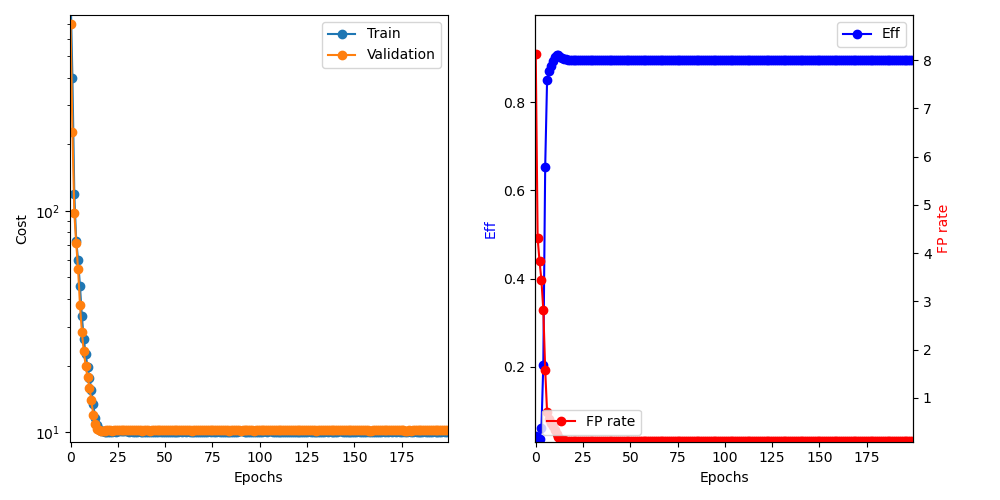

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

for model:  All_CNN6Layer_M(
  (conv1): Conv1d(1, 6, kernel_size=(11,), stride=(1,), padding=(5,))
  (conv2): Conv1d(6, 6, kernel_size=(9,), stride=(1,), padding=(4,))
  (conv3): Conv1d(6, 6, kernel_size=(9,), stride=(1,), padding=(4,))
  (conv4): Conv1d(6, 6, kernel_size=(9,), stride=(1,), padding=(4,))
  (conv5): Conv1d(6, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
)
epoch_start 220
batch_size 128
epochs 200
lr 0.001
Number of batches: train = 1250, val = 78


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 220: train=990.982, val=696.661, took 13.564 s
  Validation Found 2357 of 54504, added 81114 (eff 4.32%) (8.12 FP/event)


Epoch 221: train=397.289, val=226.237, took 13.26 s
  Validation Found 1833 of 54504, added 43056 (eff 3.36%) (4.31 FP/event)


Epoch 222: train=119.107, val=98.0614, took 12.887 s
  Validation Found 1961 of 54504, added 38254 (eff 3.60%) (3.83 FP/event)


Epoch 223: train=73.3942, val=71.3562, took 13.138 s
  Validation Found 3295 of 54504, added 34365 (eff 6.05%) (3.44 FP/event)


Epoch 224: train=59.6467, val=54.3557, took 13.274 s
  Validation Found 11157 of 54504, added 28136 (eff 20.47%) (2.82 FP/event)


Epoch 225: train=45.6893, val=37.3608, took 12.887 s
  Validation Found 35668 of 54504, added 15823 (eff 65.44%) (1.58 FP/event)


Epoch 226: train=33.3507, val=28.3091, took 12.84 s
  Validation Found 46408 of 54504, added 6972 (eff 85.15%) (0.698 FP/event)


Epoch 227: train=26.4447, val=23.1947, took 13.23 s
  Validation Found 47426 of 54504, added 5675 (eff 87.01%) (0.568 FP/event)


Epoch 228: train=22.446, val=19.9458, took 13.183 s
  Validation Found 48104 of 54504, added 4760 (eff 88.26%) (0.477 FP/event)


Epoch 229: train=19.7258, val=17.6974, took 13.829 s
  Validation Found 48748 of 54504, added 4081 (eff 89.44%) (0.409 FP/event)


Epoch 230: train=17.6164, val=15.8651, took 13.22 s
  Validation Found 49236 of 54504, added 3332 (eff 90.33%) (0.334 FP/event)


Epoch 231: train=15.5884, val=13.9279, took 12.888 s
  Validation Found 49450 of 54504, added 2584 (eff 90.73%) (0.259 FP/event)


Epoch 232: train=13.4134, val=11.9664, took 13.239 s
  Validation Found 49439 of 54504, added 1935 (eff 90.71%) (0.194 FP/event)


Epoch 233: train=11.6336, val=10.8461, took 13.337 s
  Validation Found 49226 of 54504, added 1499 (eff 90.32%) (0.15 FP/event)


Epoch 234: train=10.7235, val=10.3895, took 13.181 s
  Validation Found 49079 of 54504, added 1278 (eff 90.05%) (0.128 FP/event)


Epoch 235: train=10.3249, val=10.2107, took 12.869 s
  Validation Found 48992 of 54504, added 1151 (eff 89.89%) (0.115 FP/event)


Epoch 236: train=10.1566, val=10.1566, took 12.965 s
  Validation Found 48909 of 54504, added 1061 (eff 89.73%) (0.106 FP/event)


Epoch 237: train=10.0933, val=10.1646, took 13.094 s
  Validation Found 48865 of 54504, added 1019 (eff 89.65%) (0.102 FP/event)


Epoch 238: train=10.0728, val=10.1754, took 12.976 s
  Validation Found 48817 of 54504, added 997 (eff 89.57%) (0.0998 FP/event)


Epoch 239: train=10.0724, val=10.1864, took 13.301 s
  Validation Found 48817 of 54504, added 993 (eff 89.57%) (0.0994 FP/event)


Epoch 240: train=10.071, val=10.1872, took 12.927 s
  Validation Found 48791 of 54504, added 983 (eff 89.52%) (0.0984 FP/event)


Epoch 241: train=10.073, val=10.1896, took 12.715 s
  Validation Found 48814 of 54504, added 990 (eff 89.56%) (0.0991 FP/event)


Epoch 242: train=10.0691, val=10.1766, took 13.339 s
  Validation Found 48840 of 54504, added 1000 (eff 89.61%) (0.1 FP/event)


Epoch 243: train=10.0755, val=10.1872, took 12.633 s
  Validation Found 48835 of 54504, added 1002 (eff 89.60%) (0.1 FP/event)


Epoch 244: train=10.0742, val=10.1913, took 13.191 s
  Validation Found 48845 of 54504, added 1004 (eff 89.62%) (0.101 FP/event)


Epoch 245: train=10.0782, val=10.1901, took 13.351 s
  Validation Found 48822 of 54504, added 997 (eff 89.58%) (0.0998 FP/event)


Epoch 246: train=10.0745, val=10.1936, took 13.363 s
  Validation Found 48833 of 54504, added 1004 (eff 89.60%) (0.101 FP/event)


Epoch 247: train=10.0796, val=10.1837, took 12.986 s
  Validation Found 48813 of 54504, added 995 (eff 89.56%) (0.0996 FP/event)


Epoch 248: train=10.0781, val=10.1911, took 13.542 s
  Validation Found 48847 of 54504, added 1009 (eff 89.62%) (0.101 FP/event)


Epoch 249: train=10.082, val=10.1945, took 13.452 s
  Validation Found 48821 of 54504, added 998 (eff 89.57%) (0.0999 FP/event)


Epoch 250: train=10.0755, val=10.1843, took 13.314 s
  Validation Found 48814 of 54504, added 995 (eff 89.56%) (0.0996 FP/event)


Epoch 251: train=10.0717, val=10.1893, took 13.412 s
  Validation Found 48828 of 54504, added 1004 (eff 89.59%) (0.101 FP/event)


Epoch 252: train=10.0808, val=10.1851, took 13.41 s
  Validation Found 48826 of 54504, added 997 (eff 89.58%) (0.0998 FP/event)


Epoch 253: train=10.0734, val=10.1869, took 13.399 s
  Validation Found 48823 of 54504, added 999 (eff 89.58%) (0.1 FP/event)


Epoch 254: train=10.0698, val=10.1832, took 13.141 s
  Validation Found 48834 of 54504, added 1002 (eff 89.60%) (0.1 FP/event)


Epoch 255: train=10.0738, val=10.1876, took 13.418 s
  Validation Found 48802 of 54504, added 993 (eff 89.54%) (0.0994 FP/event)


Epoch 256: train=10.0751, val=10.1915, took 14.168 s
  Validation Found 48834 of 54504, added 1003 (eff 89.60%) (0.1 FP/event)


Epoch 257: train=10.0739, val=10.1887, took 13.804 s
  Validation Found 48815 of 54504, added 995 (eff 89.56%) (0.0996 FP/event)


Epoch 258: train=10.0705, val=10.1795, took 13.847 s
  Validation Found 48822 of 54504, added 998 (eff 89.58%) (0.0999 FP/event)


Epoch 259: train=10.0672, val=10.1875, took 13.342 s
  Validation Found 48850 of 54504, added 1006 (eff 89.63%) (0.101 FP/event)


Epoch 260: train=10.0718, val=10.181, took 13.785 s
  Validation Found 48866 of 54504, added 1010 (eff 89.66%) (0.101 FP/event)


Epoch 261: train=10.0727, val=10.1855, took 13.348 s
  Validation Found 48805 of 54504, added 988 (eff 89.54%) (0.0989 FP/event)


Epoch 262: train=10.0744, val=10.1776, took 14.058 s
  Validation Found 48809 of 54504, added 995 (eff 89.55%) (0.0996 FP/event)


Epoch 263: train=10.0738, val=10.184, took 13.889 s
  Validation Found 48811 of 54504, added 990 (eff 89.55%) (0.0991 FP/event)


Epoch 264: train=10.0705, val=10.1847, took 13.843 s
  Validation Found 48799 of 54504, added 988 (eff 89.53%) (0.0989 FP/event)


Epoch 265: train=10.0743, val=10.1813, took 13.739 s
  Validation Found 48816 of 54504, added 1000 (eff 89.56%) (0.1 FP/event)


Epoch 266: train=10.0649, val=10.1898, took 13.359 s
  Validation Found 48842 of 54504, added 1006 (eff 89.61%) (0.101 FP/event)


Epoch 267: train=10.0765, val=10.1839, took 13.815 s
  Validation Found 48831 of 54504, added 1002 (eff 89.59%) (0.1 FP/event)


Epoch 268: train=10.0708, val=10.1853, took 14.055 s
  Validation Found 48810 of 54504, added 996 (eff 89.55%) (0.0997 FP/event)


Epoch 269: train=10.0745, val=10.1816, took 13.488 s
  Validation Found 48793 of 54504, added 983 (eff 89.52%) (0.0984 FP/event)


Epoch 270: train=10.0681, val=10.1939, took 14.119 s
  Validation Found 48785 of 54504, added 985 (eff 89.51%) (0.0986 FP/event)


Epoch 271: train=10.0693, val=10.1864, took 13.221 s
  Validation Found 48838 of 54504, added 1001 (eff 89.60%) (0.1 FP/event)


Epoch 272: train=10.0669, val=10.1854, took 13.923 s
  Validation Found 48829 of 54504, added 999 (eff 89.59%) (0.1 FP/event)


Epoch 273: train=10.0726, val=10.186, took 13.762 s
  Validation Found 48830 of 54504, added 996 (eff 89.59%) (0.0997 FP/event)


Epoch 274: train=10.0699, val=10.1909, took 13.721 s
  Validation Found 48800 of 54504, added 981 (eff 89.53%) (0.0982 FP/event)


Epoch 275: train=10.0724, val=10.1938, took 13.269 s
  Validation Found 48817 of 54504, added 990 (eff 89.57%) (0.0991 FP/event)


Epoch 276: train=10.0731, val=10.1873, took 13.612 s
  Validation Found 48833 of 54504, added 1002 (eff 89.60%) (0.1 FP/event)


Epoch 277: train=10.0729, val=10.1847, took 13.614 s
  Validation Found 48829 of 54504, added 995 (eff 89.59%) (0.0996 FP/event)


Epoch 278: train=10.0748, val=10.1893, took 13.505 s
  Validation Found 48786 of 54504, added 983 (eff 89.51%) (0.0984 FP/event)


Epoch 279: train=10.0665, val=10.1842, took 13.175 s
  Validation Found 48839 of 54504, added 1001 (eff 89.61%) (0.1 FP/event)


Epoch 280: train=10.0753, val=10.1832, took 13.582 s
  Validation Found 48814 of 54504, added 993 (eff 89.56%) (0.0994 FP/event)


Epoch 281: train=10.0741, val=10.1916, took 13.32 s
  Validation Found 48832 of 54504, added 1001 (eff 89.59%) (0.1 FP/event)


Epoch 282: train=10.078, val=10.1851, took 13.465 s
  Validation Found 48836 of 54504, added 1000 (eff 89.60%) (0.1 FP/event)


Epoch 283: train=10.0728, val=10.1861, took 13.865 s
  Validation Found 48847 of 54504, added 1005 (eff 89.62%) (0.101 FP/event)


Epoch 284: train=10.0714, val=10.1798, took 13.163 s
  Validation Found 48811 of 54504, added 993 (eff 89.55%) (0.0994 FP/event)


Epoch 285: train=10.0692, val=10.1835, took 13.233 s
  Validation Found 48819 of 54504, added 996 (eff 89.57%) (0.0997 FP/event)


Epoch 286: train=10.0733, val=10.1886, took 13.473 s
  Validation Found 48835 of 54504, added 1006 (eff 89.60%) (0.101 FP/event)


Epoch 287: train=10.0716, val=10.194, took 13.383 s
  Validation Found 48800 of 54504, added 988 (eff 89.53%) (0.0989 FP/event)


Epoch 288: train=10.0684, val=10.1857, took 13.942 s
  Validation Found 48834 of 54504, added 998 (eff 89.60%) (0.0999 FP/event)


Epoch 289: train=10.0684, val=10.1848, took 13.911 s
  Validation Found 48834 of 54504, added 1000 (eff 89.60%) (0.1 FP/event)


Epoch 290: train=10.0685, val=10.183, took 13.151 s
  Validation Found 48824 of 54504, added 999 (eff 89.58%) (0.1 FP/event)


Epoch 291: train=10.0672, val=10.1804, took 13.653 s
  Validation Found 48812 of 54504, added 996 (eff 89.56%) (0.0997 FP/event)


Epoch 292: train=10.0734, val=10.1877, took 13.616 s
  Validation Found 48815 of 54504, added 996 (eff 89.56%) (0.0997 FP/event)


Epoch 293: train=10.0755, val=10.1892, took 13.547 s
  Validation Found 48826 of 54504, added 997 (eff 89.58%) (0.0998 FP/event)


Epoch 294: train=10.0713, val=10.1901, took 13.266 s
  Validation Found 48825 of 54504, added 995 (eff 89.58%) (0.0996 FP/event)


Epoch 295: train=10.0747, val=10.1865, took 13.353 s
  Validation Found 48821 of 54504, added 998 (eff 89.57%) (0.0999 FP/event)


Epoch 296: train=10.0706, val=10.1883, took 13.856 s
  Validation Found 48853 of 54504, added 1009 (eff 89.63%) (0.101 FP/event)


Epoch 297: train=10.0729, val=10.1903, took 13.418 s
  Validation Found 48807 of 54504, added 993 (eff 89.55%) (0.0994 FP/event)


Epoch 298: train=10.0746, val=10.1834, took 13.638 s
  Validation Found 48810 of 54504, added 984 (eff 89.55%) (0.0985 FP/event)


Epoch 299: train=10.0743, val=10.1876, took 13.747 s
  Validation Found 48815 of 54504, added 994 (eff 89.56%) (0.0995 FP/event)


Epoch 300: train=10.0732, val=10.1824, took 13.51 s
  Validation Found 48834 of 54504, added 1003 (eff 89.60%) (0.1 FP/event)


Epoch 301: train=10.0734, val=10.191, took 14.105 s
  Validation Found 48828 of 54504, added 1001 (eff 89.59%) (0.1 FP/event)


Epoch 302: train=10.0741, val=10.1816, took 13.63 s
  Validation Found 48814 of 54504, added 991 (eff 89.56%) (0.0992 FP/event)


Epoch 303: train=10.0711, val=10.1842, took 13.852 s
  Validation Found 48847 of 54504, added 1001 (eff 89.62%) (0.1 FP/event)


Epoch 304: train=10.0728, val=10.176, took 13.332 s
  Validation Found 48820 of 54504, added 997 (eff 89.57%) (0.0998 FP/event)


Epoch 305: train=10.0699, val=10.1828, took 13.673 s
  Validation Found 48821 of 54504, added 999 (eff 89.57%) (0.1 FP/event)


Epoch 306: train=10.0694, val=10.1877, took 13.927 s
  Validation Found 48840 of 54504, added 1005 (eff 89.61%) (0.101 FP/event)


Epoch 307: train=10.074, val=10.1872, took 13.555 s
  Validation Found 48825 of 54504, added 999 (eff 89.58%) (0.1 FP/event)


Epoch 308: train=10.0722, val=10.187, took 13.57 s
  Validation Found 48827 of 54504, added 1000 (eff 89.58%) (0.1 FP/event)


Epoch 309: train=10.0756, val=10.1942, took 13.98 s
  Validation Found 48804 of 54504, added 985 (eff 89.54%) (0.0986 FP/event)


Epoch 310: train=10.0771, val=10.1783, took 13.955 s
  Validation Found 48814 of 54504, added 992 (eff 89.56%) (0.0993 FP/event)


Epoch 311: train=10.0769, val=10.1931, took 13.606 s
  Validation Found 48805 of 54504, added 996 (eff 89.54%) (0.0997 FP/event)


Epoch 312: train=10.0702, val=10.1866, took 13.545 s
  Validation Found 48813 of 54504, added 992 (eff 89.56%) (0.0993 FP/event)


Epoch 313: train=10.0736, val=10.1815, took 14.15 s
  Validation Found 48813 of 54504, added 993 (eff 89.56%) (0.0994 FP/event)


Epoch 314: train=10.0703, val=10.1866, took 13.573 s
  Validation Found 48847 of 54504, added 1011 (eff 89.62%) (0.101 FP/event)


Epoch 315: train=10.071, val=10.1888, took 14.078 s
  Validation Found 48818 of 54504, added 1003 (eff 89.57%) (0.1 FP/event)


Epoch 316: train=10.0723, val=10.1841, took 13.288 s
  Validation Found 48830 of 54504, added 1003 (eff 89.59%) (0.1 FP/event)


Epoch 317: train=10.0683, val=10.175, took 13.696 s
  Validation Found 48824 of 54504, added 999 (eff 89.58%) (0.1 FP/event)


Epoch 318: train=10.0709, val=10.1847, took 13.462 s
  Validation Found 48836 of 54504, added 1004 (eff 89.60%) (0.101 FP/event)


Epoch 319: train=10.0742, val=10.1849, took 13.183 s
  Validation Found 48852 of 54504, added 1003 (eff 89.63%) (0.1 FP/event)


Epoch 320: train=10.0684, val=10.1817, took 13.344 s
  Validation Found 48828 of 54504, added 999 (eff 89.59%) (0.1 FP/event)


Epoch 321: train=10.0739, val=10.1829, took 13.165 s
  Validation Found 48834 of 54504, added 1001 (eff 89.60%) (0.1 FP/event)


Epoch 322: train=10.0749, val=10.1889, took 13.178 s
  Validation Found 48813 of 54504, added 992 (eff 89.56%) (0.0993 FP/event)


Epoch 323: train=10.0794, val=10.1926, took 13.173 s
  Validation Found 48831 of 54504, added 1002 (eff 89.59%) (0.1 FP/event)


Epoch 324: train=10.0732, val=10.1863, took 13.251 s
  Validation Found 48843 of 54504, added 1002 (eff 89.61%) (0.1 FP/event)


Epoch 325: train=10.0785, val=10.1836, took 13.115 s
  Validation Found 48812 of 54504, added 987 (eff 89.56%) (0.0988 FP/event)


Epoch 326: train=10.0756, val=10.1816, took 13.115 s
  Validation Found 48816 of 54504, added 992 (eff 89.56%) (0.0993 FP/event)


Epoch 327: train=10.0729, val=10.1815, took 13.159 s
  Validation Found 48850 of 54504, added 1005 (eff 89.63%) (0.101 FP/event)


Epoch 328: train=10.0736, val=10.1805, took 13.438 s
  Validation Found 48842 of 54504, added 1005 (eff 89.61%) (0.101 FP/event)


Epoch 329: train=10.072, val=10.186, took 14.542 s
  Validation Found 48818 of 54504, added 995 (eff 89.57%) (0.0996 FP/event)


Epoch 330: train=10.0712, val=10.1855, took 13.932 s
  Validation Found 48817 of 54504, added 993 (eff 89.57%) (0.0994 FP/event)


Epoch 331: train=10.0684, val=10.1843, took 13.543 s
  Validation Found 48827 of 54504, added 1000 (eff 89.58%) (0.1 FP/event)


Epoch 332: train=10.0737, val=10.1802, took 14.13 s
  Validation Found 48821 of 54504, added 997 (eff 89.57%) (0.0998 FP/event)


Epoch 333: train=10.0723, val=10.1874, took 13.639 s
  Validation Found 48811 of 54504, added 995 (eff 89.55%) (0.0996 FP/event)


Epoch 334: train=10.0711, val=10.1926, took 13.348 s
  Validation Found 48825 of 54504, added 999 (eff 89.58%) (0.1 FP/event)


Epoch 335: train=10.0731, val=10.1863, took 14.007 s
  Validation Found 48813 of 54504, added 997 (eff 89.56%) (0.0998 FP/event)


Epoch 336: train=10.072, val=10.1907, took 13.437 s
  Validation Found 48851 of 54504, added 1006 (eff 89.63%) (0.101 FP/event)


Epoch 337: train=10.07, val=10.1851, took 13.353 s
  Validation Found 48829 of 54504, added 1002 (eff 89.59%) (0.1 FP/event)


Epoch 338: train=10.0727, val=10.1843, took 13.437 s
  Validation Found 48822 of 54504, added 1001 (eff 89.58%) (0.1 FP/event)


Epoch 339: train=10.0728, val=10.1912, took 13.382 s
  Validation Found 48815 of 54504, added 989 (eff 89.56%) (0.099 FP/event)


Epoch 340: train=10.0727, val=10.191, took 13.685 s
  Validation Found 48837 of 54504, added 1004 (eff 89.60%) (0.101 FP/event)


Epoch 341: train=10.0682, val=10.188, took 13.377 s
  Validation Found 48845 of 54504, added 999 (eff 89.62%) (0.1 FP/event)


Epoch 342: train=10.0744, val=10.1883, took 13.551 s
  Validation Found 48818 of 54504, added 996 (eff 89.57%) (0.0997 FP/event)


Epoch 343: train=10.0668, val=10.1888, took 13.696 s
  Validation Found 48813 of 54504, added 998 (eff 89.56%) (0.0999 FP/event)


Epoch 344: train=10.0699, val=10.197, took 13.356 s
  Validation Found 48837 of 54504, added 1001 (eff 89.60%) (0.1 FP/event)


Epoch 345: train=10.0739, val=10.1891, took 13.822 s
  Validation Found 48830 of 54504, added 1005 (eff 89.59%) (0.101 FP/event)


Epoch 346: train=10.0746, val=10.1847, took 13.912 s
  Validation Found 48804 of 54504, added 989 (eff 89.54%) (0.099 FP/event)


Epoch 347: train=10.0717, val=10.1872, took 13.697 s
  Validation Found 48813 of 54504, added 994 (eff 89.56%) (0.0995 FP/event)


Epoch 348: train=10.0699, val=10.1811, took 13.342 s
  Validation Found 48803 of 54504, added 982 (eff 89.54%) (0.0983 FP/event)


Epoch 349: train=10.0698, val=10.1851, took 13.485 s
  Validation Found 48817 of 54504, added 998 (eff 89.57%) (0.0999 FP/event)


Epoch 350: train=10.0712, val=10.1797, took 13.853 s
  Validation Found 48837 of 54504, added 1001 (eff 89.60%) (0.1 FP/event)


Epoch 351: train=10.0727, val=10.1917, took 13.856 s
  Validation Found 48825 of 54504, added 1000 (eff 89.58%) (0.1 FP/event)


Epoch 352: train=10.0725, val=10.1948, took 13.208 s
  Validation Found 48810 of 54504, added 992 (eff 89.55%) (0.0993 FP/event)


Epoch 353: train=10.0683, val=10.1885, took 13.582 s
  Validation Found 48800 of 54504, added 986 (eff 89.53%) (0.0987 FP/event)


Epoch 354: train=10.0734, val=10.1826, took 13.96 s
  Validation Found 48813 of 54504, added 993 (eff 89.56%) (0.0994 FP/event)


Epoch 355: train=10.0777, val=10.1847, took 13.044 s
  Validation Found 48821 of 54504, added 998 (eff 89.57%) (0.0999 FP/event)


Epoch 356: train=10.0711, val=10.1851, took 14.08 s
  Validation Found 48829 of 54504, added 997 (eff 89.59%) (0.0998 FP/event)


Epoch 357: train=10.0773, val=10.1875, took 13.631 s
  Validation Found 48832 of 54504, added 1005 (eff 89.59%) (0.101 FP/event)


Epoch 358: train=10.0691, val=10.1845, took 13.85 s
  Validation Found 48798 of 54504, added 985 (eff 89.53%) (0.0986 FP/event)


Epoch 359: train=10.0736, val=10.1833, took 13.547 s
  Validation Found 48804 of 54504, added 986 (eff 89.54%) (0.0987 FP/event)


Epoch 360: train=10.0724, val=10.1848, took 14.052 s
  Validation Found 48816 of 54504, added 997 (eff 89.56%) (0.0998 FP/event)


Epoch 361: train=10.0735, val=10.1899, took 13.831 s
  Validation Found 48810 of 54504, added 989 (eff 89.55%) (0.099 FP/event)


Epoch 362: train=10.0751, val=10.1903, took 13.433 s
  Validation Found 48836 of 54504, added 998 (eff 89.60%) (0.0999 FP/event)


Epoch 363: train=10.0747, val=10.1857, took 13.81 s
  Validation Found 48820 of 54504, added 996 (eff 89.57%) (0.0997 FP/event)


Epoch 364: train=10.0696, val=10.1802, took 14.019 s
  Validation Found 48815 of 54504, added 994 (eff 89.56%) (0.0995 FP/event)


Epoch 365: train=10.0706, val=10.1926, took 13.584 s
  Validation Found 48827 of 54504, added 1001 (eff 89.58%) (0.1 FP/event)


Epoch 366: train=10.071, val=10.1916, took 13.112 s
  Validation Found 48842 of 54504, added 1008 (eff 89.61%) (0.101 FP/event)


Epoch 367: train=10.0723, val=10.1841, took 13.295 s
  Validation Found 48825 of 54504, added 996 (eff 89.58%) (0.0997 FP/event)


Epoch 368: train=10.0721, val=10.1847, took 13.419 s
  Validation Found 48839 of 54504, added 1002 (eff 89.61%) (0.1 FP/event)


Epoch 369: train=10.0735, val=10.19, took 13.401 s
  Validation Found 48800 of 54504, added 983 (eff 89.53%) (0.0984 FP/event)


Epoch 370: train=10.0706, val=10.183, took 13.38 s
  Validation Found 48843 of 54504, added 1005 (eff 89.61%) (0.101 FP/event)


Epoch 371: train=10.0703, val=10.1837, took 13.392 s
  Validation Found 48841 of 54504, added 1006 (eff 89.61%) (0.101 FP/event)


Epoch 372: train=10.0768, val=10.1837, took 13.562 s
  Validation Found 48811 of 54504, added 993 (eff 89.55%) (0.0994 FP/event)


Epoch 373: train=10.0665, val=10.1932, took 13.773 s
  Validation Found 48788 of 54504, added 982 (eff 89.51%) (0.0983 FP/event)


Epoch 374: train=10.0717, val=10.1858, took 13.294 s
  Validation Found 48816 of 54504, added 990 (eff 89.56%) (0.0991 FP/event)


Epoch 375: train=10.0706, val=10.1803, took 13.358 s
  Validation Found 48810 of 54504, added 994 (eff 89.55%) (0.0995 FP/event)


Epoch 376: train=10.0742, val=10.1893, took 13.673 s
  Validation Found 48838 of 54504, added 1001 (eff 89.60%) (0.1 FP/event)


Epoch 377: train=10.0748, val=10.1825, took 14.262 s
  Validation Found 48850 of 54504, added 1008 (eff 89.63%) (0.101 FP/event)


Epoch 378: train=10.0703, val=10.1793, took 13.754 s
  Validation Found 48814 of 54504, added 993 (eff 89.56%) (0.0994 FP/event)


Epoch 379: train=10.072, val=10.178, took 13.183 s
  Validation Found 48805 of 54504, added 985 (eff 89.54%) (0.0986 FP/event)


Epoch 380: train=10.0702, val=10.1886, took 13.863 s
  Validation Found 48814 of 54504, added 990 (eff 89.56%) (0.0991 FP/event)


Epoch 381: train=10.0656, val=10.1851, took 13.267 s
  Validation Found 48801 of 54504, added 986 (eff 89.54%) (0.0987 FP/event)


Epoch 382: train=10.0737, val=10.1907, took 13.345 s
  Validation Found 48866 of 54504, added 1016 (eff 89.66%) (0.102 FP/event)


Epoch 383: train=10.074, val=10.1855, took 13.806 s
  Validation Found 48799 of 54504, added 989 (eff 89.53%) (0.099 FP/event)


Epoch 384: train=10.0694, val=10.186, took 13.365 s
  Validation Found 48827 of 54504, added 997 (eff 89.58%) (0.0998 FP/event)


Epoch 385: train=10.0748, val=10.1865, took 13.67 s
  Validation Found 48817 of 54504, added 994 (eff 89.57%) (0.0995 FP/event)


Epoch 386: train=10.0738, val=10.1893, took 13.279 s
  Validation Found 48799 of 54504, added 988 (eff 89.53%) (0.0989 FP/event)


Epoch 387: train=10.0759, val=10.19, took 13.333 s
  Validation Found 48817 of 54504, added 995 (eff 89.57%) (0.0996 FP/event)


Epoch 388: train=10.0742, val=10.1825, took 13.811 s
  Validation Found 48810 of 54504, added 989 (eff 89.55%) (0.099 FP/event)


Epoch 389: train=10.0752, val=10.1855, took 14.157 s
  Validation Found 48801 of 54504, added 989 (eff 89.54%) (0.099 FP/event)


Epoch 390: train=10.0663, val=10.19, took 14.042 s
  Validation Found 48819 of 54504, added 999 (eff 89.57%) (0.1 FP/event)


Epoch 391: train=10.077, val=10.1852, took 13.59 s
  Validation Found 48813 of 54504, added 992 (eff 89.56%) (0.0993 FP/event)


Epoch 392: train=10.0675, val=10.1813, took 13.408 s
  Validation Found 48797 of 54504, added 983 (eff 89.53%) (0.0984 FP/event)


Epoch 393: train=10.0752, val=10.1969, took 14.225 s
  Validation Found 48817 of 54504, added 996 (eff 89.57%) (0.0997 FP/event)


Epoch 394: train=10.0692, val=10.1834, took 13.446 s
  Validation Found 48819 of 54504, added 998 (eff 89.57%) (0.0999 FP/event)


Epoch 395: train=10.0733, val=10.1813, took 14.123 s
  Validation Found 48819 of 54504, added 996 (eff 89.57%) (0.0997 FP/event)


Epoch 396: train=10.0757, val=10.1828, took 13.089 s
  Validation Found 48819 of 54504, added 997 (eff 89.57%) (0.0998 FP/event)


Epoch 397: train=10.0728, val=10.1764, took 13.639 s
  Validation Found 48827 of 54504, added 993 (eff 89.58%) (0.0994 FP/event)


Epoch 398: train=10.0694, val=10.1743, took 13.453 s
  Validation Found 48814 of 54504, added 990 (eff 89.56%) (0.0991 FP/event)


Epoch 399: train=10.0755, val=10.1864, took 13.941 s
  Validation Found 48812 of 54504, added 994 (eff 89.56%) (0.0995 FP/event)


Epoch 400: train=10.0719, val=10.1796, took 13.515 s
  Validation Found 48825 of 54504, added 1003 (eff 89.58%) (0.1 FP/event)


Epoch 401: train=10.0744, val=10.1925, took 13.392 s
  Validation Found 48814 of 54504, added 997 (eff 89.56%) (0.0998 FP/event)


Epoch 402: train=10.0815, val=10.187, took 13.234 s
  Validation Found 48821 of 54504, added 996 (eff 89.57%) (0.0997 FP/event)


Epoch 403: train=10.0662, val=10.1827, took 13.044 s
  Validation Found 48818 of 54504, added 994 (eff 89.57%) (0.0995 FP/event)


Epoch 404: train=10.0729, val=10.1874, took 13.648 s
  Validation Found 48836 of 54504, added 1002 (eff 89.60%) (0.1 FP/event)


Epoch 405: train=10.0686, val=10.1918, took 13.745 s
  Validation Found 48840 of 54504, added 1004 (eff 89.61%) (0.101 FP/event)


Epoch 406: train=10.0735, val=10.1833, took 13.873 s
  Validation Found 48827 of 54504, added 1001 (eff 89.58%) (0.1 FP/event)


Epoch 407: train=10.0773, val=10.1809, took 13.926 s
  Validation Found 48830 of 54504, added 1001 (eff 89.59%) (0.1 FP/event)


Epoch 408: train=10.0722, val=10.1863, took 13.659 s
  Validation Found 48813 of 54504, added 991 (eff 89.56%) (0.0992 FP/event)


Epoch 409: train=10.0725, val=10.1853, took 13.279 s
  Validation Found 48851 of 54504, added 1007 (eff 89.63%) (0.101 FP/event)


Epoch 410: train=10.0674, val=10.1881, took 13.903 s
  Validation Found 48819 of 54504, added 1002 (eff 89.57%) (0.1 FP/event)


Epoch 411: train=10.0689, val=10.1916, took 13.747 s
  Validation Found 48825 of 54504, added 1002 (eff 89.58%) (0.1 FP/event)


Epoch 412: train=10.0759, val=10.1869, took 14.173 s
  Validation Found 48825 of 54504, added 1001 (eff 89.58%) (0.1 FP/event)


Epoch 413: train=10.0725, val=10.1909, took 13.508 s
  Validation Found 48808 of 54504, added 986 (eff 89.55%) (0.0987 FP/event)


Epoch 414: train=10.0677, val=10.1822, took 13.505 s
  Validation Found 48819 of 54504, added 998 (eff 89.57%) (0.0999 FP/event)


Epoch 415: train=10.0677, val=10.1898, took 13.526 s
  Validation Found 48821 of 54504, added 1002 (eff 89.57%) (0.1 FP/event)


Epoch 416: train=10.072, val=10.1864, took 13.308 s
  Validation Found 48814 of 54504, added 994 (eff 89.56%) (0.0995 FP/event)


Epoch 417: train=10.0785, val=10.182, took 13.967 s
  Validation Found 48823 of 54504, added 993 (eff 89.58%) (0.0994 FP/event)


Epoch 418: train=10.0687, val=10.1909, took 13.727 s
  Validation Found 48807 of 54504, added 989 (eff 89.55%) (0.099 FP/event)


Epoch 419: train=10.0712, val=10.1874, took 13.315 s
  Validation Found 48799 of 54504, added 984 (eff 89.53%) (0.0985 FP/event)



<IPython.core.display.Javascript object>


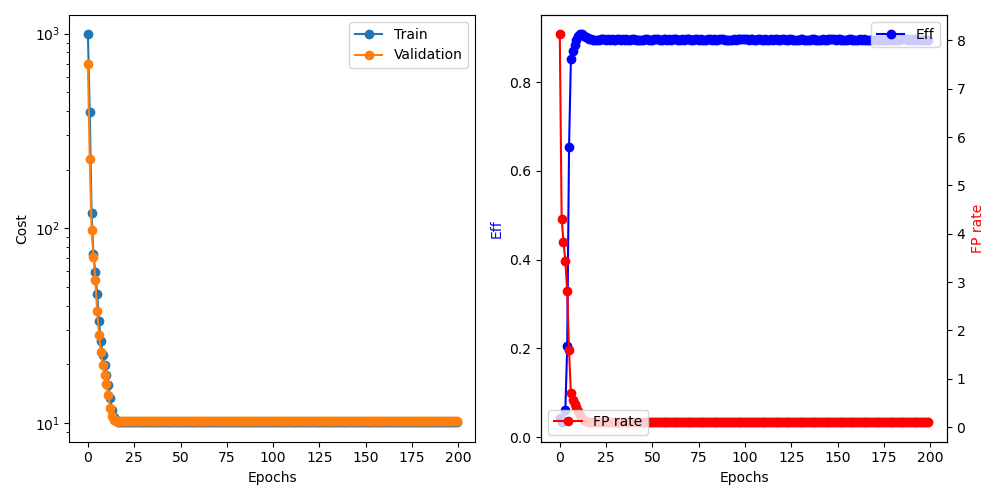

In [12]:
print('for model: ', model)   
run_name = 'SCNN to ACNN M'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
        xs = results.index

        # Update the plot above
        lines['train'].set_data(results.index, results.cost)
        lines['val'].set_data(results.index, results.val)

        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate)) 
            
        # Redraw the figure
        fig.canvas.draw()  
        
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
            
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '4')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')
        mlflow.set_tag('Extra Data', 'False')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
        
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    plt.tight_layout()
    # save plot
    fig.savefig('plot.png')  
    mlflow.log_artifact('plot.png')

In [13]:
##quit()